In [2]:
import torch
from torchvision import transforms

### Подготовка данных

In [3]:
from torchvision.datasets import MNIST

In [4]:
_tasks = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [5]:
## Load MNIST Dataset and apply transformations
mnist = MNIST('./MNIST_data', download=True, train=True, transform=_tasks)

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [7]:
## create training and validation split 
split = int(0.8 * len(mnist))
index_list = list(range(len(mnist)))
train_idx, valid_idx = index_list[:split], index_list[split:]

In [8]:
## create sampler objects using SubsetRandomSampler
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)

In [9]:
## create iterator objects for train and valid datasets
batch_size = 50
trainloader = DataLoader(mnist, batch_size=batch_size, sampler=tr_sampler)
validloader = DataLoader(mnist, batch_size=batch_size, sampler=val_sampler)

### Задаем архитектуру нейросети

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets

import numpy as np

%matplotlib inline

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Связь между параметрами свертки и шириной входного/выходного изображения:

$$W_{out} = \frac{(W_{in} - K + 2P)}{S} + 1$$

где $W_{int}$ - ширина входа, $K$ - размер ядра, $P$ - padding, $S$ - шаг

Источник: https://neurohive.io/ru/tutorial/cnn-na-pytorch/ 

In [50]:
class Net(nn.Module):
    def __init__(self, name='nn'): 
        super().__init__()
        self.name = name
        
        # сверточные слои
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) 
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) 
        
        self.drop_out = nn.Dropout() 
        
        # полносвязные слои
        self.fc1 = nn.Linear(7 * 7 * 32, 1000) 
        self.fc2 = nn.Linear(1000, 10)
        
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)
        
    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out) 
                
        out = out.reshape(out.size(0), -1) #out.view(-1, 32*7*7)
        out = self.drop_out(out) 
        
        out = self.fc1(out) 
        out = torch.tanh(out)
        out = self.fc2(out) 
        
        return out                
    
    def loss(self, output, target):                
        return F.cross_entropy(output, target) #объединяет и SoftMax и кросс-энтропийную функцию потерь

In [203]:
# аналогичная сеть, заточенная для визуализации происходящего на каждом слое
class NetPainter(nn.Module):
    def __init__(self, name='nn'): 
        super().__init__()
        self.name = name
        
        # сверточные слои
        self.layer1conv = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.layer2conv = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.drop_out = nn.Dropout() 
        
        # полносвязные слои
        self.fc1 = nn.Linear(7 * 7 * 32, 1000) 
        self.fc2 = nn.Linear(1000, 10)
        
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)
        
    def forward(self, x): 
        out = dict()
        
        # 1й сверточный слой
        y = self.layer1conv(x) 
        out['layer1conv'] = y
        y = self.relu1(y) 
        out['relu1'] = y
        y = self.pool1(y)
        out['pool1'] = y
        
        # 2й сверточный слой
        y = self.layer2conv(y) 
        out['layer2conv'] = y
        y = self.relu1(y) 
        out['relu2'] = y
        y = self.pool1(y)
        out['pool2'] = y
                
        y = y.reshape(y.size(0), -1) #out.view(-1, 32*7*7)
        out['flatten'] = y
        y = self.drop_out(y)
        out['dropout'] = y
        
        y = self.fc1(y) 
        out['dense1'] = y
        y = torch.tanh(y)
        out['denseTanh'] = y
        y = self.fc2(y) 
        out['y'] = y
        
        return out                
    
    def loss(self, output, target):                
        return F.cross_entropy(output, target) #объединяет и SoftMax и кросс-энтропийную функцию потерь

### Тренировка

######  несколько вспомогательных функций

In [107]:
# Возвращает число попаданий на проверочном наборе validloader
def get_accuracy(model, validloader):
    accuracys = np.array([])
  
    for images, targets in validloader:
        total = targets.size(0)                       
        
        with torch.no_grad():                        
            output = model(images)
            if isinstance(output, dict):
                output = output['y']
            _, pos = output.max(1)            
            correct = (pos == targets).sum().item()                            
            
            accuracys = np.append(accuracys, correct/total)
        
    accuracy = accuracys.mean()
    
    return accuracy

In [17]:
# Строит графики
def show(loss_history, metrics_history, title):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

    ax1.plot(loss_history['valid'], label='на проверочном наборе')
    ax1.plot(loss_history['train'], label='на обучающем наборе')
    ax1.grid()
    ax1.set_title(title)    
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(metrics_history['accuracy'], label='accuracy')
    ax2.grid()
    ax2.set_title(title) 
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Accuracy')
    ax2.legend();

In [18]:
# отрисовывает в черно-белом стиле изображения из массива images,
# расставляя их по матрице формы shape
def plot_mnist(images, shape, title):
    fig = plt.figure(figsize=shape[::-1], dpi=80)    
    
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    print(title, ': ')
    plt.show()

In [219]:
# Отрисовывает image - матрицу ч/б картинки
def plot_img(image, shape, title):
    fig, ax = plt.subplots(figsize=(shape[1],shape[0])) 
    ax.matshow(image, cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

    print(title)
    plt.show() 
    
# Отрисовывает серию изорбражений
# images - массив из матриц ч/б картинок
def plot_imgs(images, shape, title):    
    fig, ax = plt.subplots(figsize=(shape[1],shape[0]))
    
    for j in range(len(images)):                
        ax = fig.add_subplot(shape[0], shape[1], j+1)
        ax.matshow(images[j], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    print(title)
    plt.show() 
  
# Рисует плоский массив как график кривой
def plot_line(arr, shape, title):
    fig, ax = plt.subplots(figsize=(shape[1],shape[0]))
    
    x = np.linspace(0, arr.shape[0], arr.shape[0])
    ax.plot(x, arr)

    print(title)
    plt.show()

In [109]:
# тренирует с отслеживанием показателей
def train_eval(N_epoch, model):
    print('Model %s :' % model.name)
    
    loss_history = {'train': [], 'valid': []}
    metrics_history = {'accuracy':[]}
    
    for epoch in range(1, N_epoch): ## run the model for series of epochs
        train_loss, valid_loss = [], []
        n_batches = len(trainloader)

        ## training part 
        model.train()        
        for i, (images, targets) in enumerate(trainloader):
            model.optimizer.zero_grad()

            ## 1. прямой ход
            output = model(images)
            if isinstance(output,dict):
                output = output['y']

            ## 2. рассчет ошибки
            loss = model.loss(output, targets)

            ## 3. обратный ход
            loss.backward()

            ## 4. оптимизация весов
            model.optimizer.step()

            train_loss.append(loss.item())
            
            if (i + 1) % 200 == 0:
                print(f'Epoch: {epoch}, Batch: {i+1}/{n_batches}', end=',')
                print(f'Train Loss:{np.mean(train_loss)}')                      

        loss_history['train'].append(np.mean(train_loss))

        ## evaluation part 
        model.eval()
        for images, targets in validloader:
            output = model(images)
            if isinstance(output,dict):
                output = output['y']
            loss = model.loss(output, targets)
            valid_loss.append(loss.item())

        loss_history['valid'].append(np.mean(valid_loss))

        acc = get_accuracy(model, validloader)
        metrics_history['accuracy'].append(acc)

        print(f'Epoch: {epoch}', end=',')
        print(f'Valid Loss: {np.mean(valid_loss)}', end=',')
        print(f'Accuracy: {acc}')
            
    return (model, loss_history, metrics_history)

######  собственно обучение

In [212]:
# Запускаем обучение сети с акцентом на визуализацю внутренней кухни
modelsP =[NetPainter('nn_painter')]

historyP = []
for i, model in enumerate(modelsP):
    N_epochs = 10
      
    net, loss_history, metrics_history = train_eval(N_epochs,model)
    historyP.append({'net': net, 'loss': loss_history, 'metrics': metrics_history })

Model nn_painter :
Epoch: 1, Batch: 300/960,Train Loss:0.7662642677128315
Epoch: 1, Batch: 600/960,Train Loss:0.5142818065360188
Epoch: 1, Batch: 900/960,Train Loss:0.4081796696864896
Epoch: 1,Valid Loss: 0.1167858636006713,Accuracy: 0.9665833333333335
Epoch: 2, Batch: 300/960,Train Loss:0.15381707639743886
Epoch: 2, Batch: 600/960,Train Loss:0.148422033249711
Epoch: 2, Batch: 900/960,Train Loss:0.1435640639687578
Epoch: 2,Valid Loss: 0.08027099220004554,Accuracy: 0.9769166666666668
Epoch: 3, Batch: 300/960,Train Loss:0.11545201296607653
Epoch: 3, Batch: 600/960,Train Loss:0.11461615851148962
Epoch: 3, Batch: 900/960,Train Loss:0.11012186537910666
Epoch: 3,Valid Loss: 0.06362805047732158,Accuracy: 0.98125
Epoch: 4, Batch: 300/960,Train Loss:0.09370324226096273
Epoch: 4, Batch: 600/960,Train Loss:0.09497235668512682
Epoch: 4, Batch: 900/960,Train Loss:0.09377810703331811
Epoch: 4,Valid Loss: 0.05900311847605432,Accuracy: 0.9837500000000001
Epoch: 5, Batch: 300/960,Train Loss:0.086252819

### Визуализируем результаты обучения

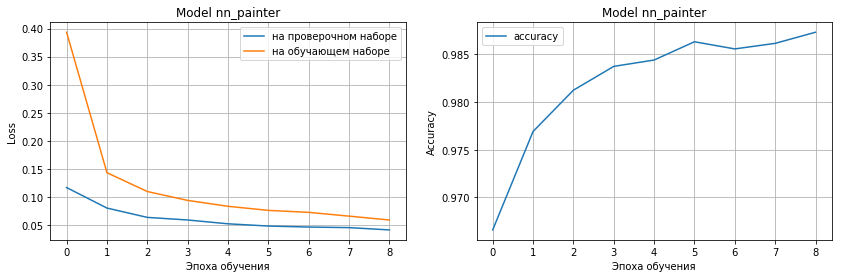

In [213]:
# Визуализируем показатели обучения
for way in historyP:
    show(way['loss'], way['metrics'], 'Model ' + way['net'].name) 

Батч из тестового набора : 


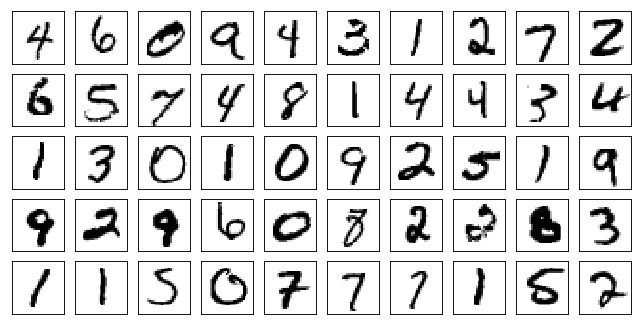

Что увидела нейросеть: 
 tensor([4, 6, 0, 9, 4, 3, 1, 2, 7, 2, 6, 5, 7, 4, 8, 1, 4, 4, 3, 4, 1, 3, 0, 1,
        0, 9, 2, 5, 1, 9, 9, 2, 9, 6, 0, 8, 2, 2, 8, 3, 1, 1, 5, 0, 7, 7, 7, 1,
        5, 2])
Правильных ответов 50 из 50


In [214]:
# Посмотрим результаты в виде вход-выход на примере одного из батчей
data, targets = next(iter(validloader))

plot_mnist(data.data.numpy(), (5, 10), 'Батч из тестового набора')

modelka = modelsP[0]
output = modelka(data)

_, pos = output['y'].max(1)
print(f'Что увидела нейросеть: \n {pos}')

correct = (pos == targets).sum().item()
total = targets.size(0)
print(f'Правильных ответов {correct} из {total}')

#### Посмотрим на процесс преобразования входного изображения по слоям

Батч-1 Картинка-1:


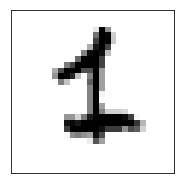

Карты признаков после 1й свертки:


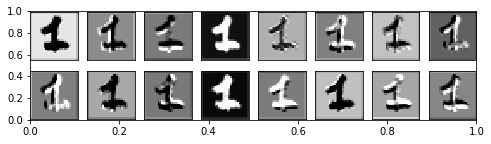

Карты признаков после 1й ReLU:


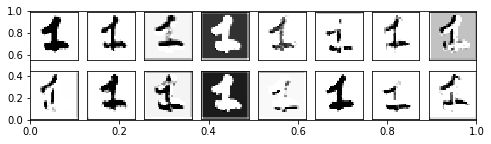

Карты признаков после 1го MaxPool-a:


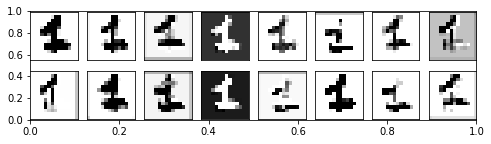

Карты признаков после 2й свертки:


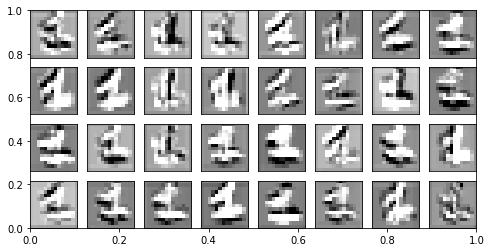

Карты признаков после 2й ReLU:


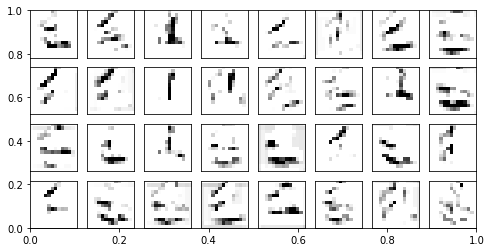

Карты признаков после 2го MaxPool-a:


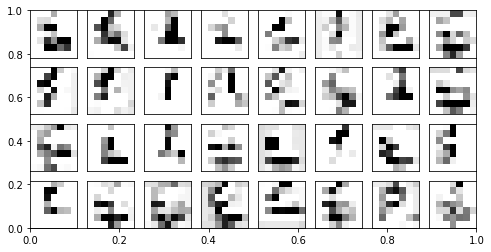

In [215]:
modelka = modelsP[0]

data, targets = next(iter(validloader))

image = data.data.numpy()[0][0]
plot_img(image, (3,5), 'Батч-1 Картинка-1:')
  
output = modelka(data)

# 1й сверточный слой
feature_maps_1 = output['layer1conv'][0]
fm1_to_plot = ((feature_maps_1.view(-1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
plot_imgs(fm1_to_plot, (2, 8), 'Карты признаков после 1й свертки:')

feature_maps_1_act = output['relu1'][0]
fm1_act_to_plot = ((feature_maps_1_act.view(-1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
plot_imgs(fm1_act_to_plot, (2, 8), 'Карты признаков после 1й ReLU:')

feature_maps_1_pool = output['pool1'][0]
fm1_act_pool_to_plot = ((feature_maps_1_pool.view(-1, 14, 14)+1)*0.5).clamp(0, 1).data.numpy()
plot_imgs(fm1_act_pool_to_plot, (2, 8), 'Карты признаков после 1го MaxPool-a:')

# 2й сверточный слой
feature_maps_2 = output['layer2conv'][0]
fm2_to_plot = ((feature_maps_2.view(-1, 14, 14)+1)*0.5).clamp(0, 1).data.numpy()
plot_imgs(fm2_to_plot, (4, 8), 'Карты признаков после 2й свертки:')

feature_maps_2_act = output['relu2'][0]
fm2_act_to_plot = ((feature_maps_2_act.view(-1, 14, 14)+1)*0.5).clamp(0, 1).data.numpy()
plot_imgs(fm2_act_to_plot, (4, 8), 'Карты признаков после 2й ReLU:')

feature_maps_2_pool = output['pool2'][0]
fm2_act_pool_to_plot = ((feature_maps_2_pool.view(-1, 7, 7)+1)*0.5).clamp(0, 1).data.numpy()
plot_imgs(fm2_act_pool_to_plot, (4, 8), 'Карты признаков после 2го MaxPool-a:')

Вход 1го полносвязного слоя:


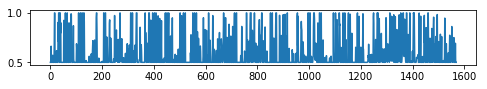

Выход 1го полносвязного слоя (tanh):


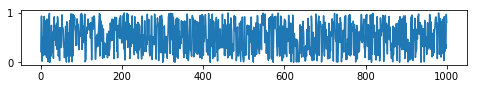

Выход сети (2го полносвязного слоя):


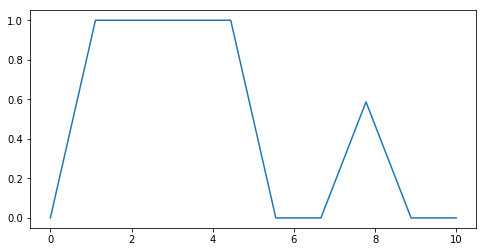

Нейросеть считает, что это цифра 1


In [220]:
## 1й полносвязный слой
flatten_1 = output['flatten'][0]
flat_to_plot = ((flatten_1+1)*0.5).clamp(0, 1).data.numpy()
plot_line(flat_to_plot, (1,8), 'Вход 1го полносвязного слоя:')

dense_1 = output['denseTanh'][0]
dense1_to_plot = ((dense_1+1)*0.5).clamp(0, 1).data.numpy()
plot_line(dense1_to_plot, (1,8), 'Выход 1го полносвязного слоя (tanh):')

## 2й полносвязный слой
dense_2 = output['y'][0]
dense2_to_plot = ((dense_2+1)*0.5).clamp(0, 1).data.numpy()
plot_line(dense2_to_plot, (4,8), 'Выход сети (2го полносвязного слоя):')

## В итоге
_, pos = output['y'][0].max(0)
print(f'Нейросеть считает, что это цифра {pos.item()}')

### Источники

1. https://neurohive.io/ru/tutorial/cnn-na-pytorch/